### Part 0: Cellular Automata Model On Network Structure


Cellular automata(CA) is discrete dynamical system in space and time consisting of a set of scattered cellular in analog space. Every state in the time sequence of cellular in every moment, is synchronize updated by cells around on the last time via same effect rules (local rules). In this project, we consider to combine the CA system rules with networkx structure to simulate the information spread trend in a real social work.

## The information spread in the network to be modeled and simulated
In the information diffusion process in social networks, cell of cellular automata can be assumed to be a individual member of the network (node), and cellular space can be assumed as the entire network. Cellular state parameters can be described as the individual characteristic parameters of a member state, cellular automata neighbors represents the range of individual members interaction.

Exercise: develop a SIR based information transmission model as following:

Grid/ node structure: a random Barabasi_Albert social network connection

State and information spread rules of each node:

Health node (S): Users who have not received the piece of information and can  readily transfer the information.

Transmission node (I): Users who have received the information and transfer it to others. The transmission probability $p_1=0.5$. If a transmission node has already spread the information, then it would become an immune node which means the probability of this node changing to an immune node is 1.

Immune node (R): Users who will not spread information to others, but may become a transmission node if it is repeatedly contacted by other transmission nodes. The probability $p_2$ that the immune node becomes a transmission node  depends on its neighbors  ($p_2$= the total number of transmission neighbor nodes/ the total number of neighbors). 


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy

In [11]:
# States
HEALTH = 0
TRANSMISSION = 1
IMMUNE = 2 # immune & inactive

class social_network():
    def __init__(self,  alpha=0.1,beta=0.3, n = 4039,name = "ws",k = 57, p=0.5,m = 6):
        # Generation of random graphs
        if name == "ws":# Watts–Strogatz Graph
            self.name = "Watts–Strogatz"
            self.graph = nx.watts_strogatz_graph(n, k = 57, p=0.5)
        elif name == "ba":# Barabási–Albert Graph
            self.name = "Barabási–Albert"
            self.graph = nx.barabasi_albert_graph(n, m = 6)
        elif name == "real": # The social network data from facebook
            self.name = "Facebook"
            self.graph,n = self.read_graph(filename = "../data/facebook_combined.txt")
            
        init_dist=np.random.choice([TRANSMISSION,IMMUNE,HEALTH],
                         size = n,p=(alpha,beta,1-alpha-beta))
        # list of nodes group by status
        self.healthy_list = np.where(init_dist==HEALTH)[0].tolist()
        self.transmission_list = np.where(init_dist==TRANSMISSION)[0].tolist()
        self.immmune_list = np.where(init_dist==IMMUNE)[0].tolist()
        for i in range(0,n):
            self.graph.node[i]['status'] = init_dist[i]
    
    def read_graph(self,filename):
        # reading real social network data into a Graph object
        G = nx.Graph()
        lines = [line.rstrip('\n') for line in open(filename, 'r')] 
        edge_list=list(map(lambda edge: [int(edge.split()[0]), int(edge.split()[1])], lines))
        G.add_edges_from(edge_list)
        n = G.number_of_nodes()
        return G,n
            
            
    def recording_changing_immune(self):
        # recording the immune node that will be changed to transmission node
        
        g = self.graph
        im_to_be_changed_to_trans = []
        for ni in self.immmune_list:
            immune_neighbors = np.array(g.neighbors(ni))
            immune_neighbors_status = np.array([g.node[nei]['status'] 
                                                for nei in g.neighbors(ni)])
            # computing the probability for one immune node becoming transmission node
            p2 = len(immune_neighbors[np.where(
                immune_neighbors_status == TRANSMISSION)[0]]) / len(immune_neighbors)
            if np.random.uniform(0,1) < p2*0.1:
                im_to_be_changed_to_trans.append(ni)
        
        return im_to_be_changed_to_trans
    
    
    def changing_transmission_and_healthy(self, p1):
        # finish the (transmission ==> immune) & (healthy ==> transmission)
        # p1: the probability for transmission node affecting its neighbors
        g = self.graph
        for nt in self.transmission_list:
            neighbors = np.array(g.neighbors(nt))
            neighbors_status = np.array([g.node[nei]['status'] 
                                         for nei in g.neighbors(nt)])
            healthy_neighbors = neighbors[np.where(neighbors_status == HEALTH)[0]]
            spreaded_neighbors = healthy_neighbors[np.where(np.random.uniform(0,1,(healthy_neighbors.shape[0],)) 
                                      < p1)[0]]
            if spreaded_neighbors.size!=0:    # if information has spread to the neighbors of the transmission node
                self.transmission_list.remove(nt)
                self.immmune_list.append(nt)
                g.node[nt]['status'] = IMMUNE
                for sn in spreaded_neighbors:
                    self.healthy_list.remove(sn)
                    self.transmission_list.append(sn)
                    g.node[sn]['status'] = TRANSMISSION
              
            
    def changing_immune(self, im_to_be_changed_to_trans): 
        # transform the recorded immune nodes' status
        g = self.graph
        for ni in im_to_be_changed_to_trans:
            g.node[ni]['status'] = TRANSMISSION
            self.immmune_list.remove(ni)
            self.transmission_list.append(ni)
    
    
    def one_step(self, p1):
        g = self.graph
        # Conflicts Resolving Strategy:
        # first record the immune nodes that would change to be transmission,
        # but not actually change the status
        im_to_be_changed_to_trans = self.recording_changing_immune()
        self.changing_transmission_and_healthy(p1)
        self.changing_immune(im_to_be_changed_to_trans)
        return (len(self.healthy_list), len(self.transmission_list), len(self.immmune_list))
    
    def iteration(self, n = 100, p1 = 0.5):
        # using the counting list to record the nodes' number in every iteration
        cnt_list=[(len(self.healthy_list), 
                   len(self.transmission_list), 
                   len(self.immmune_list))]
        for i in range(n - 1):
            cnt_list.append(self.one_step(p1))
        return cnt_list


In [7]:
def plot_simulation(graph, iteration_num = 50):
    x=list(range(0,iteration_num))
    records=np.array(graph.iteration(n = iteration_num))
    plt.plot(x, records[:,0].tolist(),label="healthy")
    plt.plot(x, records[:,1].tolist(),label="transmission")
    plt.plot(x, records[:,2].tolist(),label="immmune")
    plt.legend()
    plt.title("Simulation of {} Network".format(graph.name))
    return records

### simulation with the real social network data from facebook

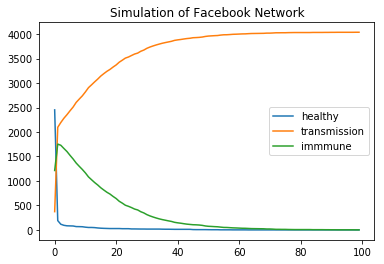

In [12]:
# social network graph
RealRecords = plot_simulation(social_network(name ="real",alpha=0.1,beta=0.3), iteration_num = 100)